<!--BOOK_INFORMATION-->
<img align="left" style="padding-right:10px;" src="figures/PDSH-cover-small.png">
*This notebook contains an excerpt from the [Python Data Science Handbook](http://shop.oreilly.com/product/0636920034919.do) by Jake VanderPlas; the content is available [on GitHub](https://github.com/jakevdp/PythonDataScienceHandbook).*

*The text is released under the [CC-BY-NC-ND license](https://creativecommons.org/licenses/by-nc-nd/3.0/us/legalcode), and code is released under the [MIT license](https://opensource.org/licenses/MIT). If you find this content useful, please consider supporting the work by [buying the book](http://shop.oreilly.com/product/0636920034919.do)!*

<!--NAVIGATION-->
< [In Depth: k-Means Clustering](05.11-K-Means.ipynb) | [Contents](Index.ipynb) | [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) >

# In Depth: Gaussian Mixture Models

The *k*-means clustering model explored in the previous section is simple and relatively easy to understand, but its simplicity leads to practical challenges in its application.
In particular, the non-probabilistic nature of *k*-means and its use of simple distance-from-cluster-center to assign cluster membership leads to poor performance for many real-world situations.
In this section we will take a look at Gaussian mixture models (GMMs), which can be viewed as an extension of the ideas behind *k*-means, but can also be a powerful tool for estimation beyond simple clustering.

We begin with the standard imports:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np

## Motivating GMM: Weaknesses of k-Means

Let's take a look at some of the weaknesses of *k*-means and think about how we might improve the cluster model.
As we saw in the previous section, given simple, well-separated data, *k*-means finds suitable clustering results.

For example, if we have simple blobs of data, the *k*-means algorithm can quickly label those clusters in a way that closely matches what we might do by eye:

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

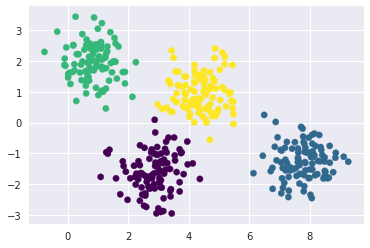

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

From an intuitive standpoint, we might expect that the clustering assignment for some points is more certain than others: for example, there appears to be a very slight overlap between the two middle clusters, such that we might not have complete confidence in the cluster assigment of points between them.
Unfortunately, the *k*-means model has no intrinsic measure of probability or uncertainty of cluster assignments (although it may be possible to use a bootstrap approach to estimate this uncertainty).
For this, we must think about generalizing the model.

One way to think about the *k*-means model is that it places a circle (or, in higher dimensions, a hyper-sphere) at the center of each cluster, with a radius defined by the most distant point in the cluster.
This radius acts as a hard cutoff for cluster assignment within the training set: any point outside this circle is not considered a member of the cluster.
We can visualize this cluster model with the following function:

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

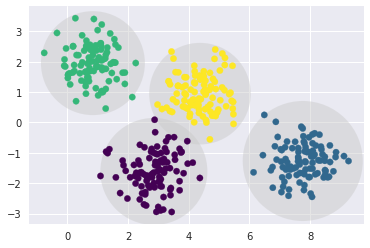

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

An important observation for *k*-means is that these cluster models *must be circular*: *k*-means has no built-in way of accounting for oblong or elliptical clusters.
So, for example, if we take the same data and transform it, the cluster assignments end up becoming muddled:

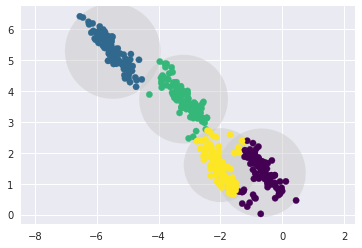

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

By eye, we recognize that these transformed clusters are non-circular, and thus circular clusters would be a poor fit.
Nevertheless, *k*-means is not flexible enough to account for this, and tries to force-fit the data into four circular clusters.
This results in a mixing of cluster assignments where the resulting circles overlap: see especially the bottom-right of this plot.
One might imagine addressing this particular situation by preprocessing the data with PCA (see [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb)), but in practice there is no guarantee that such a global operation will circularize the individual data.

These two disadvantages of *k*-means—its lack of flexibility in cluster shape and lack of probabilistic cluster assignment—mean that for many datasets (especially low-dimensional datasets) it may not perform as well as you might hope.

You might imagine addressing these weaknesses by generalizing the *k*-means model: for example, you could measure uncertainty in cluster assignment by comparing the distances of each point to *all* cluster centers, rather than focusing on just the closest.
You might also imagine allowing the cluster boundaries to be ellipses rather than circles, so as to account for non-circular clusters.
It turns out these are two essential components of a different type of clustering model, Gaussian mixture models.

## Generalizing E–M: Gaussian Mixture Models

A Gaussian mixture model (GMM) attempts to find a mixture of multi-dimensional Gaussian probability distributions that best model any input dataset.
In the simplest case, GMMs can be used for finding clusters in the same manner as *k*-means:

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivaria

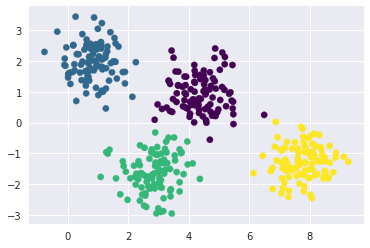

In [7]:
from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

But because GMM contains a probabilistic model under the hood, it is also possible to find probabilistic cluster assignments—in Scikit-Learn this is done using the ``predict_proba`` method.
This returns a matrix of size ``[n_samples, n_clusters]`` which measures the probability that any point belongs to the given cluster:

In [8]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[ 0.525  0.     0.     0.475]
 [ 0.     0.     1.     0.   ]
 [ 0.     0.     1.     0.   ]
 [ 1.     0.     0.     0.   ]
 [ 0.     0.     1.     0.   ]]


/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)


We can visualize this uncertainty by, for example, making the size of each point proportional to the certainty of its prediction; looking at the following figure, we can see that it is precisely the points at the boundaries between clusters that reflect this uncertainty of cluster assignment:

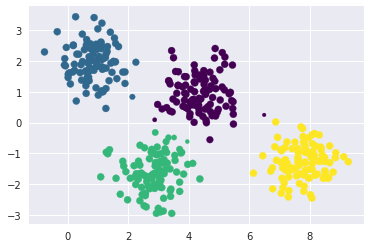

In [9]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

Under the hood, a Gaussian mixture model is very similar to *k*-means: it uses an expectation–maximization approach which qualitatively does the following:

1. Choose starting guesses for the location and shape

2. Repeat until converged:

   1. *E-step*: for each point, find weights encoding the probability of membership in each cluster
   2. *M-step*: for each cluster, update its location, normalization, and shape based on *all* data points, making use of the weights

The result of this is that each cluster is associated not with a hard-edged sphere, but with a smooth Gaussian model.
Just as in the *k*-means expectation–maximization approach, this algorithm can sometimes miss the globally optimal solution, and thus in practice multiple random initializations are used.

Let's create a function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output:

In [10]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

With this in place, we can take a look at what the four-component GMM gives us for our initial data:

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivaria

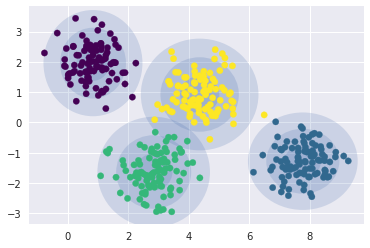

In [11]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)

Similarly, we can use the GMM approach to fit our stretched dataset; allowing for a full covariance the model will fit even very oblong, stretched-out clusters:

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivaria

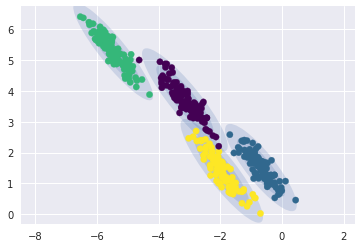

In [12]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

This makes clear that GMM addresses the two main practical issues with *k*-means encountered before.

### Choosing the covariance type

If you look at the details of the preceding fits, you will see that the ``covariance_type`` option was set differently within each.
This hyperparameter controls the degrees of freedom in the shape of each cluster; it is essential to set this carefully for any given problem.
The default is ``covariance_type="diag"``, which means that the size of the cluster along each dimension can be set independently, with the resulting ellipse constrained to align with the axes.
A slightly simpler and faster model is ``covariance_type="spherical"``, which constrains the shape of the cluster such that all dimensions are equal. The resulting clustering will have similar characteristics to that of *k*-means, though it is not entirely equivalent.
A more complicated and computationally expensive model (especially as the number of dimensions grows) is to use ``covariance_type="full"``, which allows each cluster to be modeled as an ellipse with arbitrary orientation.

We can see a visual representation of these three choices for a single cluster within the following figure:

![(Covariance Type)](figures/05.12-covariance-type.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Covariance-Type)

## GMM as *Density Estimation*

Though GMM is often categorized as a clustering algorithm, fundamentally it is an algorithm for *density estimation*.
That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

As an example, consider some data generated from Scikit-Learn's ``make_moons`` function, which we saw in [In Depth: K-Means Clustering](05.11-K-Means.ipynb):

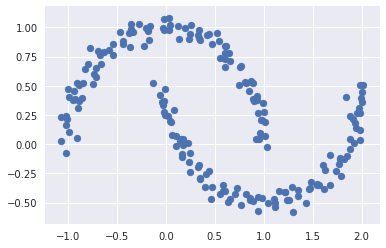

In [13]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivaria

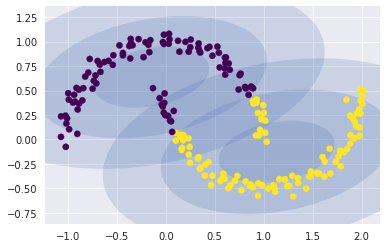

In [14]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivaria

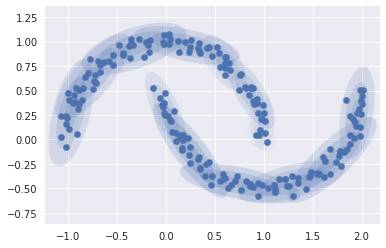

In [15]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall *distribution* of the input data.
This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input.
For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

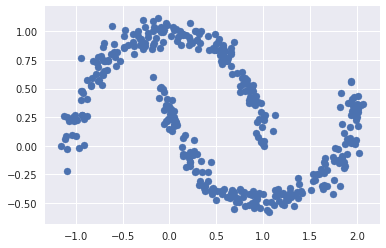

In [16]:
Xnew = gmm16.sample(400, random_state=42)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

### How many components?

The fact that GMM is a generative model gives us a natural means of determining the optimal number of components for a given dataset.
A generative model is inherently a probability distribution for the dataset, and so we can simply evaluate the *likelihood* of the data under the model, using cross-validation to avoid over-fitting.
Another means of correcting for over-fitting is to adjust the model likelihoods using some analytic criterion such as the [Akaike information criterion (AIC)](https://en.wikipedia.org/wiki/Akaike_information_criterion) or the [Bayesian information criterion (BIC)](https://en.wikipedia.org/wiki/Bayesian_information_criterion).
Scikit-Learn's ``GMM`` estimator actually includes built-in methods that compute both of these, and so it is very easy to operate on this approach.

Let's look at the AIC and BIC as a function as the number of GMM components for our moon dataset:

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivaria

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarnin

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_norm

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarnin

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarnin

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivaria

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarnin

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_norm

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarnin

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_norm

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarnin

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarnin

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_norm

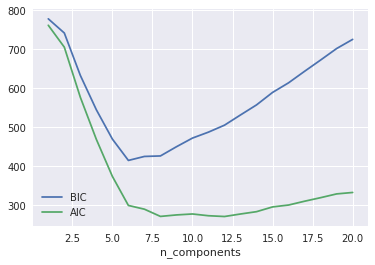

In [17]:
n_components = np.arange(1, 21)
models = [GMM(n, covariance_type='full', random_state=0).fit(Xmoon)
          for n in n_components]

plt.plot(n_components, [m.bic(Xmoon) for m in models], label='BIC')
plt.plot(n_components, [m.aic(Xmoon) for m in models], label='AIC')
plt.legend(loc='best')
plt.xlabel('n_components');

The optimal number of clusters is the value that minimizes the AIC or BIC, depending on which approximation we wish to use. The AIC tells us that our choice of 16 components above was probably too many: around 8-12 components would have been a better choice.
As is typical with this sort of problem, the BIC recommends a simpler model.

Notice the important point: this choice of number of components measures how well GMM works *as a density estimator*, not how well it works *as a clustering algorithm*.
I'd encourage you to think of GMM primarily as a density estimator, and use it for clustering only when warranted within simple datasets.

## Example: GMM for Generating New Data

We just saw a simple example of using GMM as a generative model of data in order to create new samples from the distribution defined by the input data.
Here we will run with this idea and generate *new handwritten digits* from the standard digits corpus that we have used before.

To start with, let's load the digits data using Scikit-Learn's data tools:

In [18]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

Next let's plot the first 100 of these to recall exactly what we're looking at:

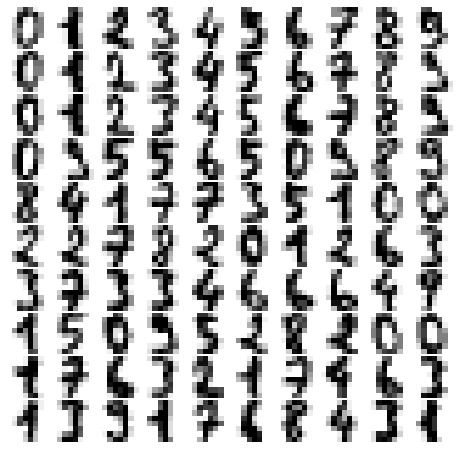

In [19]:
def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

We have nearly 1,800 digits in 64 dimensions, and we can build a GMM on top of these to generate more.
GMMs can have difficulty converging in such a high dimensional space, so we will start with an invertible dimensionality reduction algorithm on the data.
Here we will use a straightforward PCA, asking it to preserve 99% of the variance in the projected data:

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(0.99, whiten=True)
data = pca.fit_transform(digits.data)
data.shape

(1797, 41)

The result is 41 dimensions, a reduction of nearly 1/3 with almost no information loss.
Given this projected data, let's use the AIC to get a gauge for the number of GMM components we should use:

In [ ]:
n_components = np.arange(50, 210, 10)
models = [GMM(n, covariance_type='full', random_state=0)
          for n in n_components]
aics = [model.fit(data).aic(data) for model in models]
plt.plot(n_components, aics);

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class GaussianMixture instead.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:57: DeprecationWarning: Class GMM is deprecated; The class GMM is deprecated in 0.18 and will be  removed in 0.20. Use class Gaussia

/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function distribute_covar_matrix_to_match_covariance_type is deprecated; The function distribute_covar_matrix_to_match_covariance_typeis deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function log_multivariate_normal_density is deprecated; The function log_multivariate_normal_density is deprecated in 0.18 and will be removed in 0.20.
  warnings.warn(msg, category=DeprecationWarning)
/srv/venv/lib/python3.6/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarnin

It appears that around 110 components minimizes the AIC; we will use this model.
Let's quickly fit this to the data and confirm that it has converged:

In [ ]:
gmm = GMM(110, covariance_type='full', random_state=0)
gmm.fit(data)
print(gmm.converged_)

Now we can draw samples of 100 new points within this 41-dimensional projected space, using the GMM as a generative model:

In [ ]:
data_new = gmm.sample(100, random_state=0)
data_new.shape

Finally, we can use the inverse transform of the PCA object to construct the new digits:

In [ ]:
digits_new = pca.inverse_transform(data_new)
plot_digits(digits_new)

The results for the most part look like plausible digits from the dataset!

Consider what we've done here: given a sampling of handwritten digits, we have modeled the distribution of that data in such a way that we can generate brand new samples of digits from the data: these are "handwritten digits" which do not individually appear in the original dataset, but rather capture the general features of the input data as modeled by the mixture model.
Such a generative model of digits can prove very useful as a component of a Bayesian generative classifier, as we shall see in the next section.

<!--NAVIGATION-->
< [In Depth: k-Means Clustering](05.11-K-Means.ipynb) | [Contents](Index.ipynb) | [In-Depth: Kernel Density Estimation](05.13-Kernel-Density-Estimation.ipynb) >

In [ ]:
testing complete; Gopal